<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_7_Light_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BA%D1%86%D0%B8%D0%B9_%D0%9B%D1%83%D0%BA%D0%BE%D0%B9%D0%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light задание. Вариант 1

Используя шаблон ноутбука, напишите загрузку данных и прогнозирование акций Лукойла на 1 шаг с помощью Dense и Conv1D сетей (две отдельные сети). Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками

---
Light задание. Вариант 2
База Лукойл
1. Обучите простую полносвязную сеть для прогнозирования временного ряда
(только close) и визуализируйте результат.
2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд
прямым способом и визуализируйте результат.
3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10
шагам предсказания (10 графиков на разных отдельных осях).
4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или
LSTM слои.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import figure
%matplotlib inline

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv1D, LSTM, GlobalMaxPooling1D, MaxPooling1D, LocallyConnected1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, Nadam

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import utils
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики

In [ ]:
#Формируем параметры загрузки данных
xLen = 300      #Анализируем по 300 прошедшим точкам 
valLen = 30000  #Используем 30.000 записей для проверки 
batch_size=20   #Размер batch, который будем скармливать модели #хороший результат при 20
target = 3      # 'CLOSE'

## Загружаем данные

In [ ]:
#Считываем данные
import os
os.chdir('/content/drive/My Drive/Занятие_7_Временные ряды/data/акции лукойл/')
base_data18_19 = pd.read_csv('18_19.csv', sep=';')
base_data16_17 = pd.read_csv('16_17.csv', sep=';')
base_data18_19.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
data16_17 = base_data16_17.iloc[:,2:]
data18_19 = base_data18_19.iloc[:,2:]
print(data16_17.index)
print(data18_19.index, '\n')
data18_19.head()

RangeIndex(start=0, stop=263925, step=1)
RangeIndex(start=0, stop=217947, step=1) 



,OPEN,MAX,MIN,CLOSE,VOLUME
0,3341.0,3356.0,3340.0,3355.0,6088
1,3355.0,3359.0,3353.0,3353.0,1624
2,3351.5,3357.5,3351.5,3357.5,722
3,3354.5,3360.0,3354.5,3358.0,3034
4,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
df = pd.concat([data16_17, data18_19])
print(df.iloc[0], '\n')
data = np.array(df) # Превратили в массив numpy
data.shape

OPEN      2351.0
MAX       2355.8
MIN       2350.0
CLOSE     2350.0
VOLUME    2547.0
Name: 0, dtype: float64 



(481872, 5)

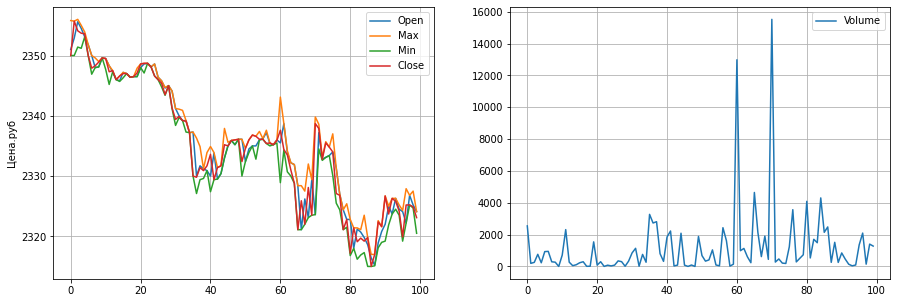

In [ ]:
plt.figure(figsize=(15, 5))

start = 0       
stop = 100 
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

plt.subplot(1,2,1)
for i in range(4):
  plt.plot(data[start:start+stop, i], label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.grid()
plt.show()

## Подготовка данных

In [ ]:
# Цикл для прогноза изпенений цены CLOSE (разности текущее - предыдущее)
#ddata = np.zeros((len(data), 1))
#for i in range(1, len(data)):
#    ddata[i] = data[i, target] - data[i - 1, target] # приращения (текущее - предыдущее)
    # в этом сеть должна предсказывать не следущее значение, а на сколько изменится текущее значение в следующий момент
#ddata[0] = 0.

In [ ]:
trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]
print('xTrain: ', xTrain.shape, 'xTest:', xTest.shape)
xScaler = MinMaxScaler() #Масштабируем X чтобы их легче было скормить сетке
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению Close
yTrain, yTest = data[:trainLen, target], data[trainLen+xLen+2:, target]
print('yTrain: ', yTrain.shape, 'yTest:', yTest.shape)
yTrain, yTest = np.reshape(data[:trainLen, target],(-1,1)), np.reshape(data[trainLen+xLen+2:, target],(-1,1))
yScaler = MinMaxScaler() #Масштабируем Y чтобы их легче было скормить сетке
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)
print('yTrain: ', yTrain.shape, 'yTest:', yTest.shape)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,       
                    length = xLen,      # Длина выходных последовательностей (по количеству временных интервалов)
                    stride = 1,         # Период между последовательными выходными последовательностями
                    sampling_rate = 1,  # Период между последовательными отдельными временными шагами внутри последовательностей
                    batch_size = batch_size)                

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                     length = xLen, stride = 1,
                     batch_size = batch_size)

print('\nlen(trainDataGen) = ', len(trainDataGen), 'len(testDataGen) = ', len(testDataGen))

xTrain:  (451872, 5) xTest: (29698, 5)
yTrain:  (451872,) yTest: (29698,)
yTrain:  (451872, 1) yTest: (29698, 1)

len(trainDataGen) =  22579 len(testDataGen) =  1470


In [ ]:
print('yTrain:', yTrain[0], '\nxtrain:', xTrain[0])
print('\nРазмерности после TimeseriesGenerator (X)(Y): ', trainDataGen[0][0].shape, trainDataGen[0][1].shape)

yTrain: [0.07810564] 
xtrain: [0.07839171 0.07822035 0.07839814 0.07810564 0.00059283]

Размерности после TimeseriesGenerator (X)(Y):  (20, 300, 5) (20, 1)


## Функции визуализации результатов

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.grid()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Создаем нейросеть

### Dense

In [ ]:
input = Input(shape = (xLen, 5))
x = Dense(150, activation='linear')(input)
x = Flatten()(x)
x = Dense(1, activation='linear')(x)
modelD = Model(input, x)

#plot_model(modelD, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = modelD.fit_generator(trainDataGen, epochs=20, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])

Epoch 1/20
22579/22579 [==============================] - 58s 3ms/step - loss: 0.0030 - val_loss: 1.1725e-04
Epoch 2/20
22579/22579 [==============================] - 58s 3ms/step - loss: 2.0892e-04 - val_loss: 1.5463e-05
Epoch 3/20
22579/22579 [==============================] - 59s 3ms/step - loss: 9.7496e-05 - val_loss: 4.5218e-05
Epoch 4/20
22579/22579 [==============================] - 57s 3ms/step - loss: 5.5476e-05 - val_loss: 1.0237e-05
Epoch 5/20
22579/22579 [==============================] - 58s 3ms/step - loss: 4.3565e-05 - val_loss: 8.4536e-06
Epoch 6/20
22568/22579 [============================>.] - ETA: 0s - loss: 3.5844e-05
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
22579/22579 [==============================] - 58s 3ms/step - loss: 3.5832e-05 - val_loss: 5.2570e-05
Epoch 7/20
22579/22579 [==============================] - 58s 3ms/step - loss: 5.0809e-06 - val_loss: 1.0557e-05
Epoch 8/20
22579/22579 [==============================] - 

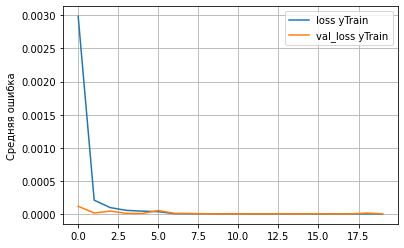

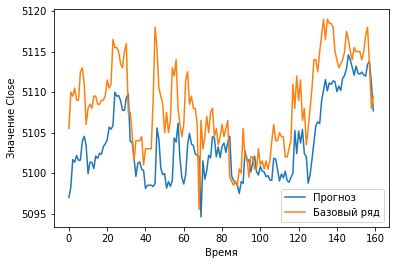

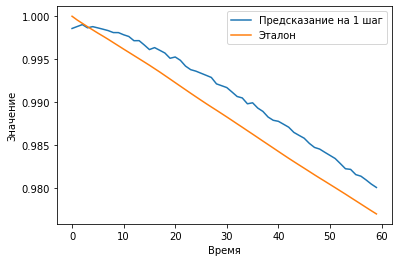

In [ ]:
#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

### Conv1D

In [ ]:
input = Input(shape = (xLen, 5))
x = Conv1D(5, 2, padding='same', activation='relu')(input)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(100, activation='linear')(x)
x = Dense(1, activation='linear')(x)
modelC = Model(input, x)

#plot_model(modelC, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#Компилируем
modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = modelC.fit_generator(trainDataGen, epochs=20, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])

Epoch 1/20
22579/22579 [==============================] - 61s 3ms/step - loss: 0.0014 - val_loss: 2.5432e-05
Epoch 2/20
22579/22579 [==============================] - 59s 3ms/step - loss: 4.1993e-04 - val_loss: 1.3365e-05
Epoch 3/20
22579/22579 [==============================] - 59s 3ms/step - loss: 1.3056e-04 - val_loss: 4.7074e-05
Epoch 4/20
22579/22579 [==============================] - 60s 3ms/step - loss: 4.4969e-05 - val_loss: 1.3751e-05
Epoch 5/20
22579/22579 [==============================] - 60s 3ms/step - loss: 2.6519e-05 - val_loss: 4.8923e-05
Epoch 6/20
22579/22579 [==============================] - 60s 3ms/step - loss: 2.1652e-05 - val_loss: 1.0190e-05
Epoch 7/20
22579/22579 [==============================] - 60s 3ms/step - loss: 1.7090e-05 - val_loss: 7.0281e-06
Epoch 8/20
22562/22579 [============================>.] - ETA: 0s - loss: 1.3631e-05
Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
22579/22579 [==============================] - 

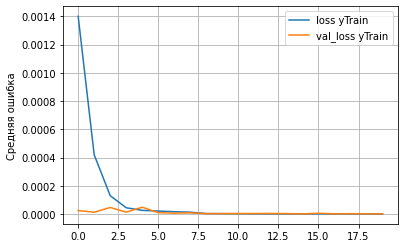

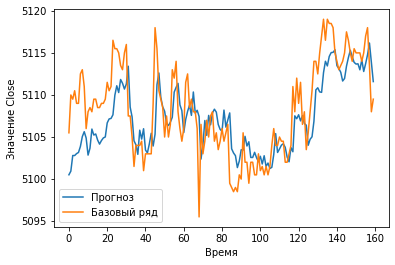

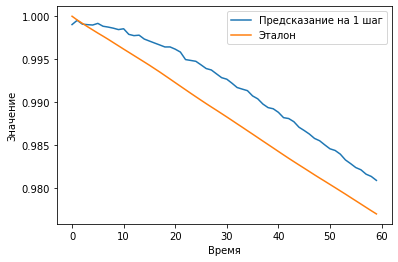

In [ ]:
#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

### LocallyConnected1D

In [ ]:
input = Input(shape = (xLen, 5))
x = LocallyConnected1D(5, 2, activation='relu')(input)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(100, activation='linear')(x)
x = Dense(1, activation='linear')(x)
modelC = Model(input, x)

#plot_model(modelC, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#Компилируем
modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = modelC.fit_generator(trainDataGen, epochs=20, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
22579/22579 [==============================] - 153s 7ms/step - loss: 1.5581e-04 - val_loss: 1.4097e-05
Epoch 2/20
22579/22579 [==============================] - 151s 7ms/step - loss: 2.1684e-05 - val_loss: 3.7939e-05
Epoch 3/20
22579/22579 [==============================] - 153s 7ms/step - loss: 1.4163e-05 - val_loss: 7.0312e-06
Epoch 4/20
22579/22579 [==============================] - 152s 7ms/step - loss: 1.0202e-05 - val_loss: 5.4905e-06
Epoch 5/20
22573/22579 [============================>.] - ETA: 0s - loss: 8.5954e-06
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
22579/22579 [==============================] - 153s 7ms/step - loss: 8.6008e-06 - val_loss: 6.3944e-06
Epoch 6/20
22579/22579 [==============================] - 152s 7ms/step - loss: 3.5185e-06 - val_loss: 4.1370e-06
Epoch 7/20
22579/22579 [==============================] - 156s 7ms/step - loss: 3.388

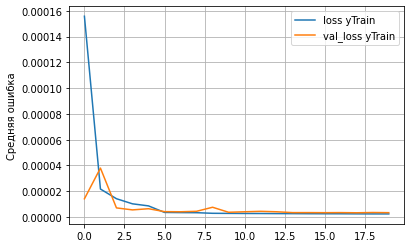

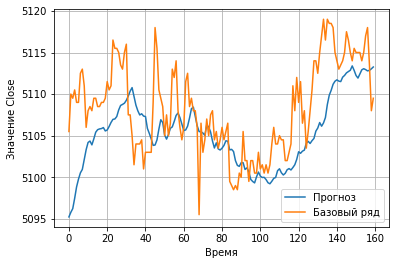

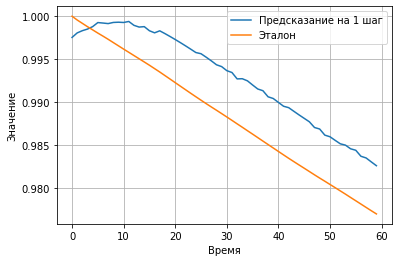

In [ ]:
#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

### LSTM (5-10) - хорошая!

In [ ]:
input = Input(shape = (xLen, 5))
x = LSTM(5)(input)
x = Dense(10, activation='linear')(x)
x = Dense(1, activation='linear')(x)
modelL = Model(input, x)

#plot_model(modelL, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#Компилируем
modelL.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = modelL.fit_generator(trainDataGen, epochs=20, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])

Epoch 1/20
22579/22579 [==============================] - 316s 14ms/step - loss: 0.0163 - val_loss: 4.5269e-06
Epoch 2/20
22579/22579 [==============================] - 316s 14ms/step - loss: 1.6137e-06 - val_loss: 1.9223e-06
Epoch 3/20
22579/22579 [==============================] - 316s 14ms/step - loss: 1.3847e-06 - val_loss: 1.2518e-06
Epoch 4/20
22579/22579 [==============================] - 316s 14ms/step - loss: 1.3205e-06 - val_loss: 1.9560e-06
Epoch 5/20
22577/22579 [============================>.] - ETA: 0s - loss: 1.2609e-06
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
22579/22579 [==============================] - 314s 14ms/step - loss: 1.2609e-06 - val_loss: 1.3929e-06
Epoch 6/20
22579/22579 [==============================] - 308s 14ms/step - loss: 8.0046e-07 - val_loss: 9.8029e-07
Epoch 7/20
22579/22579 [==============================] - 306s 14ms/step - loss: 7.9830e-07 - val_loss: 9.7981e-07
Epoch 8/20
22579/22579 [====================

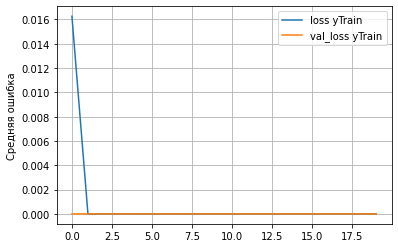

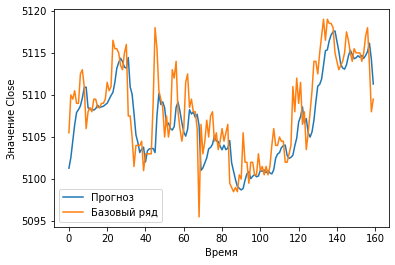

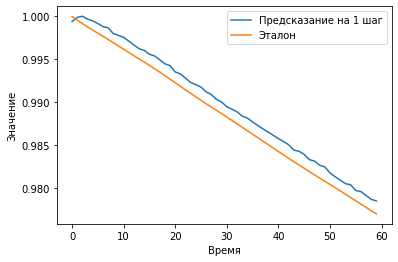

In [ ]:
#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = modelL #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

# Выводы:
-----
1. Иногда лучнее - враг хорошего. И нужно серьезно подумать, прежде чем усложнять сеть с помощью concatenate
